# to do
add label
add text to graph


In [10]:
import pickle
import pandas as pd
import numpy as np

from CPR import main

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [11]:
with open('d_hh.pkl', 'rb') as file:
    d_hh = pickle.load(file)
    
def create_dataframe(d_hh):
    l_p = ['byear', 'sex', 'ret_age', 'education', 'init_wage', 'pension',
           'bal_rrsp', 'bal_tfsa', 'bal_other_reg', 'bal_unreg',
           'cont_rate_rrsp', 'cont_rate_tfsa', 'cont_rate_other_reg',
           'cont_rate_unreg', 'withdrawal_rrsp', 'withdrawal_tfsa',
           'withdrawal_other_reg', 'withdrawal_unreg', 'replacement_rate_db',
           'rate_employee_db', 'income_previous_db', 'init_dc',
           'rate_employee_dc', 'rate_employer_dc', 'claim_age_cpp',
           'cap_gains_unreg', 'realized_losses_unreg', 'init_room_rrsp',
           'init_room_tfsa']
    l_sp = ['s_' + var for var in l_p]
    l_hh = ['weight', 'couple', 'prov', 'first_residence', 'second_residence',
            'price_first_residence', 'price_second_residence', 'business',
            'price_business', 'mix_bonds', 'mix_bills', 'mix_equity', 'fee',
            'fee_equity', 'credit_card', 'personal_loan', 'student_loan',
            'car_loan', 'credit_line', 'first_mortgage', 'second_mortgage',
            'other_debt', 'credit_card_payment', 'personal_loan_payment',
            'student_loan_payment', 'car_loan_payment', 'credit_line_payment',
            'first_mortgage_payment', 'second_mortgage_payment',
            'other_debt_payment']   
    return pd.DataFrame(d_hh, columns=l_p + l_sp + l_hh, index=[0])
df = create_dataframe(d_hh)

## Effect of uncertainty

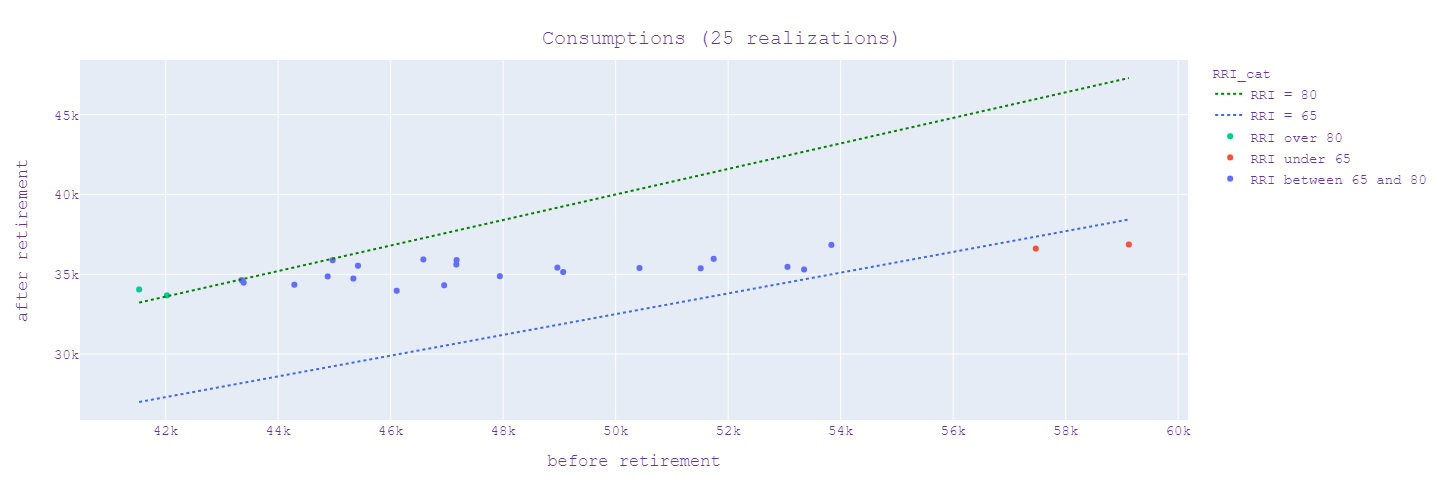

In [61]:
import plotly.graph_objects as go
import plotly.express as px

nsim = 25
results = main.run_simulations(df, nsim=nsim, n_jobs=1, non_stochastic=False,
                               base_year=2020)
df_output = results.output
df_output['RRI'] = (df_output.cons_after / df_output.cons_bef * 100).round(1)
df_output['RRI_cat'] = pd.cut(df_output.RRI, bins=[0, 65, 80, np.inf],
                              labels=["RRI under 65", "RRI between 65 and 80", "RRI over 80"])

fig = go.Figure()
fig = px.scatter(df_output, x="cons_bef", y="cons_after", color="RRI_cat",
                 hover_data={'RRI_cat':False,
                             'cons_bef':':,.0f',
                             'cons_after':':,.0f',
                             'RRI':':,.0f'})

cons_bef = np.array([df_output.cons_bef.min(), df_output.cons_bef.max()])
fig.add_trace(go.Scatter(x=cons_bef, y=.65 * cons_bef,
                         mode='lines', name="RRI = 65",
                         line=dict(color="RoyalBlue", width=2, dash='dot')))
fig.add_trace(go.Scatter(x=cons_bef, y=.80 * cons_bef,
                         mode='lines', name="RRI = 80",
                         line=dict(color="Green", width=2, dash='dot')))

fig.update_layout(height=500, width=700,
                  title={'text': f"Consumptions ({nsim} realizations)",
                         'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  xaxis_title="before retirement",
                  yaxis_title="after retirement",
                  font=dict(family="Courier New, monospace",
                            size=14, color="RebeccaPurple"),
                  legend={'traceorder':'reversed'}
)
fig.show()

## Change contribution rate rrsp and retirement age

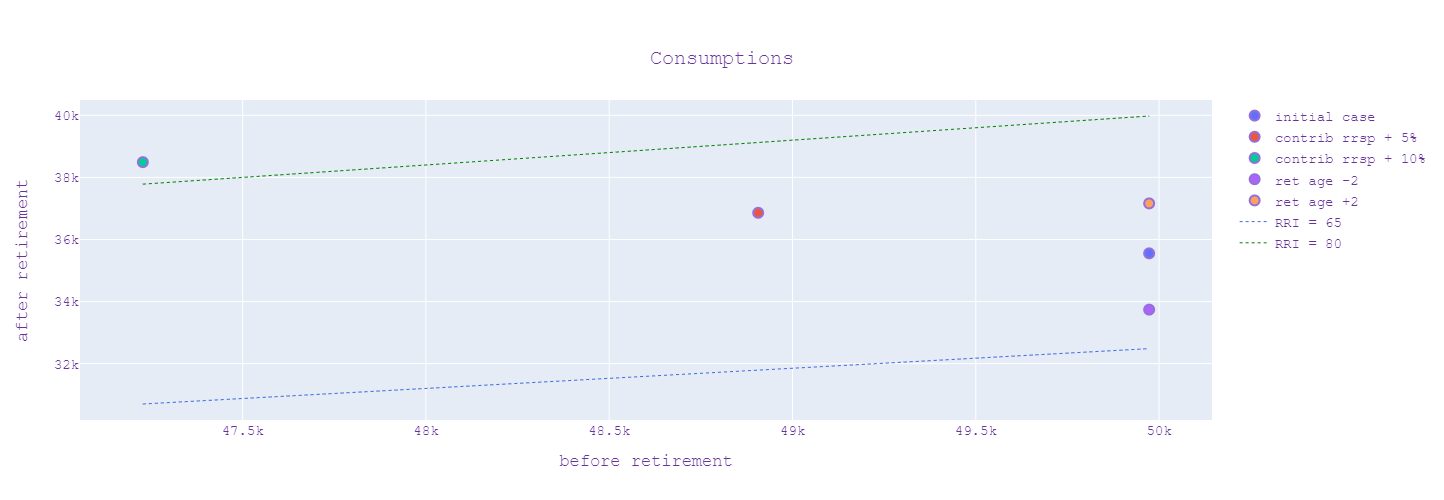

In [58]:
def create_data_changes(df):
    df_change = pd.DataFrame(np.repeat(df.values, 5, axis=0), columns=df.columns)
    df_change.cont_rate_rrsp += np.array([0, 0.05, 0.10, 0, 0])
    df_change.ret_age += np.array([0, 0, 0, -2, 2])
    if any(df_change.couple) is True:
        df_change.s_ret_age += np.array([0, 0, 0, -2, 2])
    return df_change

df_change = create_data_changes(df)
results = main.run_simulations(df_change, nsim=1, n_jobs=1, non_stochastic=True, base_year=2020)
results.merge()
df_change = results.df_merged

names = ['initial case', 'contrib rrsp + 5%', 'contrib rrsp + 10%', 'ret age -2', 'ret age +2']
init_cons_bef, init_cons_after = df_change.loc[0, ['cons_bef', 'cons_after']].values.squeeze().tolist()

fig = go.Figure()

l_cons_bef = []
for index, row in df_change.iterrows():
    l_cons_bef.append(row['cons_bef'])
    fig.add_scatter(x=[row['cons_bef']], y=[row['cons_after']],
                    mode='markers', 
                    marker=dict(size=10, line=dict(color='MediumPurple', width=2)),
                    name=names[index])
    
#     fig.add_annotation(
#         x=row['cons_bef'],  # arrows' head
#         y=row['cons_after'],  # arrows' head
#         ax=init_cons_bef,  # arrows' tail
#         ay=init_cons_after,  # arrows' tail
#         xref='x',
#         yref='y',
#         axref='x',
#         ayref='y',
#         text='',  # if you want only the arrow
#         showarrow=True,
#         arrowhead=2,
#         arrowsize=1,
#         arrowwidth=2,
#         arrowcolor='black',
#         opacity=0.5
#     )

cons_bef = np.array([min(l_cons_bef), max(l_cons_bef)])
fig.add_trace(go.Scatter(x=cons_bef, y=.65 * cons_bef,
                         mode='lines', name="RRI = 65",
                         line=dict(color="RoyalBlue", width=1, dash='dot')))
fig.add_trace(go.Scatter(x=cons_bef, y=.80 * cons_bef,
                         mode='lines', name="RRI = 80",
                         line=dict(color="Green", width=1, dash='dot')))


fig.update_layout(height=500, width=700,
                  title={'text': f"Consumptions",
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis_title="before retirement",
                  yaxis_title="after retirement",
                  font=dict(family="Courier New, monospace",
                            size=14,
                            color="RebeccaPurple")
)
fig.show()

# Income Decomposition

In [14]:
hhold

byear                                    1978
sex                                      male
ret_age                                    65
education                          university
init_wage                             60000.0
pension                               20000.0
bal_rrsp                              10000.0
bal_tfsa                              20000.0
bal_other_reg                             0.0
bal_unreg                              5000.0
cont_rate_rrsp                         0.0005
cont_rate_tfsa                         0.0003
cont_rate_other_reg                    0.0003
cont_rate_unreg                        0.0001
withdrawal_rrsp                        1000.0
withdrawal_tfsa                        1000.0
withdrawal_other_reg                      0.0
withdrawal_unreg                          0.0
replacement_rate_db                       NaN
rate_employee_db                          NaN
income_previous_db                        NaN
init_dc                           

In [15]:
hhold.couple

False

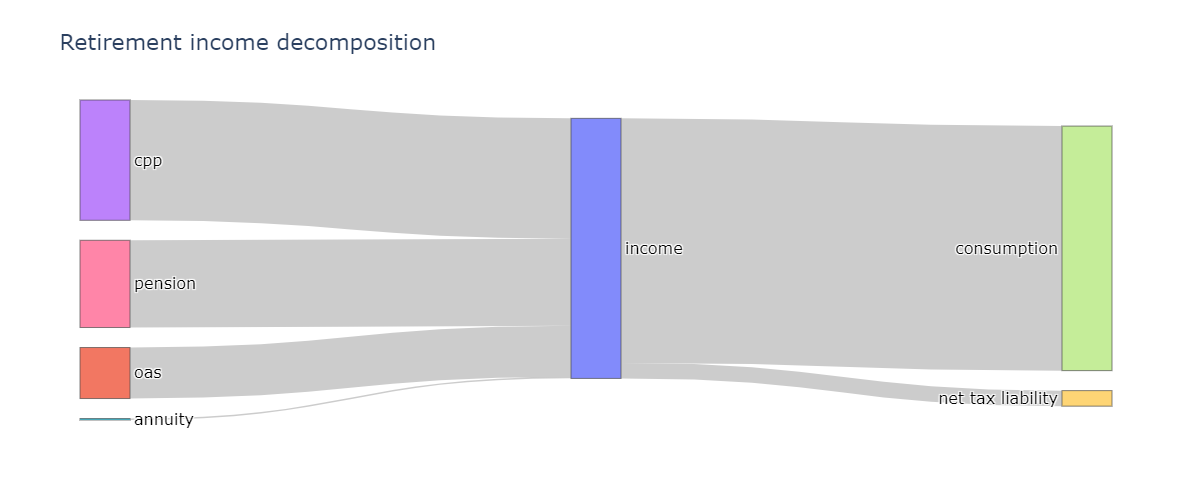

In [16]:
# prepare data
hhold = df_change.loc[0, :]
pension = hhold['pension_after']
annuity = hhold['annuity_rrsp_after'] + hhold['annuity_rpp_dc_after'] + hhold['annuity_non_rrsp_after']
consumption = hhold['cons_after']
debt_payments = hhold['debt_payments_after']
net_liabilities = hhold['fam_net_tax_liability_after']
cpp = hhold['cpp_after']
gis = hhold['gis_after']
oas = hhold['oas_after']
rpp_db = hhold['rpp_db_benefits_after']
if hhold.couple:
    pension += hhold['s_pension_after']
    annuity += hhold['s_annuity_rrsp_after'] + hhold['s_annuity_rpp_dc_after'] + hhold['s_annuity_non_rrsp_after']
    cpp = hhold['s_cpp_after']
    gis = hhold['s_gis_after']
    oas = hhold['s_oas_after']
    rpp_db = hhold['s_rpp_db_benefits_after']

income = oas + gis + cpp + rpp_db + annuity + pension

label = ['income', # 0
         'oas', 'gis', 'cpp', 'RPP DB', 'annuity', 'pension', # 1 to 6
         'consumption', 'debt payments', # 7 - 8
         'net tax liability']  # 9 could also enter income (invert source and target)
if net_liabilities > 0:
    source = [1, 2, 3, 4, 5, 6, 0, 0, 0]
    target = [0, 0, 0, 0, 0, 0, 7, 8, 9]
    value =  [oas, gis, cpp, rpp_db, annuity, pension, consumption, debt_payments, net_liabilities]
else:
    source = [1, 2, 3, 4, 5, 6, 0, 0, 9]
    target = [0, 0, 0, 0, 0, 0, 7, 8, 0]
    value =  [oas, gis, cpp, rpp_db, annuity, pension, consumption, debt_payments, -net_liabilities]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=20, thickness=50)

data = go.Sankey(link=link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(height=500, width=1000,
                  title_text="Retirement income decomposition",
                  font_size=16)
fig.show()